# **Classificazione dei prodotti di Scattering Elettrone-Protone**

Confronto tra diversi modelli di *apprendimento supervisionato* per la *classificazione* di particelle prodotte durante uno scattering inelastico elettrone-protone basato sulla risposta di sei diversi rilevatori. L'obiettivo è quello di identificare le particelle e valutare il migliore modello tra i seguenti:

- **Decision Tree**
- **Random Forest**
- **Multilayer Perceptron**

I dati utilizzati sono il prodotto della risposta di sei diversi rilevatori mediante la piattaforma di simulazione *[GEANT4](https://geant4.web.cern.ch/)*. Il DataSet è reperibile su *[Kaggle](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)*.

## **Analisi Esplorativa dei dati**

Importo i moduli e le librerie di interesse, utili per l'analisi del dataset.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Carico il dataset in locale.

In [47]:
df = pd.read_csv("..\GEANT4_Simulation.csv")
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


Per una maggiore leggibilità rinomino la colonna **id** e **nphe**.

Inoltre sostituisco il *codice* associato a ciascuna particella con il suo **nome** rimappando i valori. Per tale operazione uso il metodo [`dict.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html).

In [48]:
# Dizionario contente l'associazione chiave valore id:nome

dictParticelle = { -11 : 'positrone',
                  211 : 'pione',
                  321 : 'kaone',
                  2212 : 'protone'}

**Composizione DataSet**

|    Features    |              Significato              | Unità di Misura |
| :-------------: | :------------------------------------: | :--------------: |
|  **id**  |            Nome Particella            |    $NoDim$    |
|   **p**   |           Quantità di moto           |    $GeV/c$    |
| **theta** |          Angolo di Scattering          |     $rad$     |
| **beta** | Rapporto tra la velocità$v$ e $c$ |    $NoDim$    |
| **nphe** |        Numero di fotoelettroni        |    $NoDim$    |
|  **ein**  |          Energia in ingresso          |     $GeV$     |
| **eout** |           Energia in uscita           |     $GeV$     |


**Valore Particelle**

|    id    |              Particella              | Simbolo |        Massa (MeV)   |  
| :-------------: | :------------------------------------: | :--------------: | :--------: |
|  **(-11)**  |            Positrone            |    $e^+$    | $0.51$ |
|   **(211)**   |           Pione           |    $\pi \quad (\pi^0,\pi^+,\pi^-)$    | $133$ |
| **(321)** |          Kaone          |     $K \quad (K^0,K^+,K^-)$      | $495$ |
| **(2212)** | Protone |     $p$     | $940$ |


In [49]:
# Rinomino le colonne 'id' e 'nphe'
df.rename(columns={'id' : 'particella'}, inplace=True)
df.rename(columns={'nphe' : 'elettroni'}, inplace=True)

# Rimappo i valori della colonna 'particella'
df['particella'] = df['particella'].map(dictParticelle)

In [50]:
df.head(10)

,particella,p,theta,beta,elettroni,ein,eout
0,pione,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0,0.034379,0.049256
5,pione,0.403296,0.694215,0.958553,0,0.000000,0.000000
6,protone,1.382620,0.436689,0.844835,0,0.200275,0.053651
7,protone,1.133130,0.276831,0.781295,0,0.044038,0.093980
8,protone,0.656291,0.542507,0.560291,0,0.083406,0.000000
9,protone,2.077210,0.130479,0.909951,0,0.036164,0.045960


Controllo adesso se per qualche particella mancano delle feature e verifico la dimensionalità del dataframe. Per farlo uso [`pd.DataFrame.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) e [`pd.DataFrame.sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html).

In [51]:
print(df.isnull().sum())
print("-"*20)
print(df.shape)

particella    0
p             0
theta         0
beta          0
elettroni     0
ein           0
eout          0
dtype: int64
--------------------
(5000000, 7)


Ci sono cinque milioni di particelle, ciascuna con sei features e nessun dato è mancante.

Osservando il dataset ipotizzo che il rilevatore circa gli *elettroni* è stato **inneficente** (segna spesso 0). Verifico questa ipotosi e eventualmente elimino la colonna prima dell'addestramento dei modelli.

In [52]:
flop = df['elettroni'].value_counts(normalize = True)
print('Il rilevatore manca il segnale il {volte:.2%} delle volte'.format(volte=flop[0]))

Il rilevatore manca il segnale il 93.52% delle volte


Pertanto posso eliminare la feature **elettroni**, in quanto non significativa.

In [53]:
df.drop(columns = ['elettroni'], inplace=True)

Inoltre posso rimuovere anche quei dati **fisicamente non coerenti** dovuti a un'inefficienza dei detector o errori di tipo statistico, valutando tutti quelle particelle che superano il valore di threshold:

**$\beta=\frac{v}{c}\geq1$**

In [54]:
df = df.drop(df[df.beta >= 1].index)
df.head()

,particella,p,theta,beta,ein,eout
0,pione,0.780041,1.081480,0.989962,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0.034379,0.049256


Osservo ora in che proporzione stanno i prodotti tra di loro.

pione        51.708008
protone      43.128496
kaone         5.001575
positrone     0.161921
Name: particella, dtype: float64


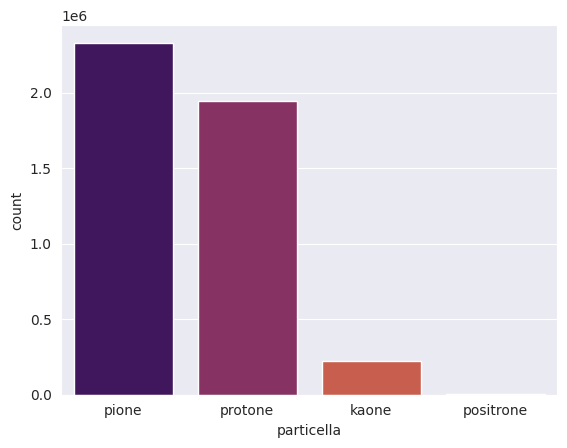

In [55]:
with sns.axes_style("darkgrid"):
    sns.countplot(x = df['particella'],
                palette='inferno')

print(df['particella'].value_counts(normalize = True) * 100)

Come si può vedere i **positroni** e **kaoni** sono rispettivamente solo un $5\%$ circa e lo $0.16\%$, ossia sono classi *sottorappresentate*. Pertanto è necessario effettuare un **resampling** del dataset in maniera tale da rendere tutte le classi equirappresentate e non avere un dataset sbilanciato.

In particolare andremo ad effettuare un **undersampling**, implementato Scikit Learn attraverso l'oggetto `RandomUnderSampler` offerto dalla libreria [`imbalanced Learn`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html).

In [56]:
# Mostro il numero di particelle per ciascuna classe 
sp = df['particella'].value_counts()
print(sp)

pione        2332465
protone      1945457
kaone         225613
positrone       7304
Name: particella, dtype: int64


In [57]:
from imblearn.under_sampling import RandomUnderSampler

In [58]:
# Resampling - Undersampling
x = pd.DataFrame(df)
y = x['particella']

undersample = RandomUnderSampler(sampling_strategy='not minority')
df_us, _ = undersample.fit_resample(x, y)

kaone        7304
pione        7304
positrone    7304
protone      7304
Name: particella, dtype: int64


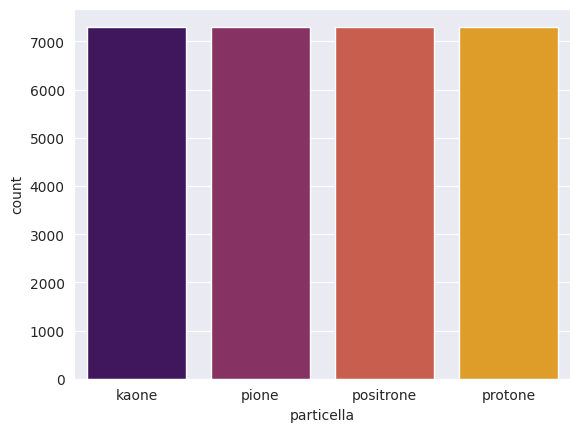

In [59]:
# Mostro il nuovo numero di particelle per ciascuna classe
print(df_us['particella'].value_counts())

with sns.axes_style("darkgrid"):
    sns.countplot(x = df_us['particella'],
                palette='inferno')

In [61]:
print("Numero di Particelle nel DataSet Iniziale: {}\n".format(df.shape[0]))
print("Numero di Particelle nel DataSet Finale: {}\n".format(df_us.shape[0]))
print("Il DataSet è stato ridotto del {:.2%}".format((df.shape[0]-df_us.shape[0])/df.shape[0]))

Numero di Particelle nel DataSet Iniziale: 4510839

Numero di Particelle nel DataSet Finale: 29216

Il DataSet è stato ridotto del 99.35%


Ora che il dataset è bilanciato, vedo se c'è qualche correlazione tra le feature mediante una matrice di correlazione.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

<AxesSubplot:>

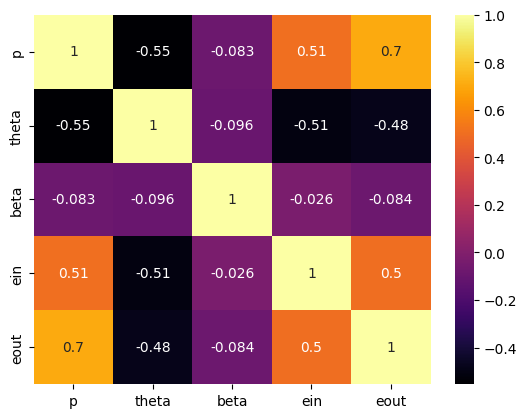

In [62]:
sns.heatmap(df_us.corr(method="spearman"), annot=True, cmap="inferno")

L'unica correlazione significativa che posso individuare è tra la *quantità di moto* e l'*energia in uscita*: fisicamente ciò è coerente, poichè le particelle più veloci sono anche le più energetiche.


Considerando il **$\beta$** e **$p$** invece, sicuramente non ho una correlazione lineare, ma osservo in che rapporto sono tra loro, poichè so teoricamente che la velocità relativistica è legata all'impulso come segue:

$$\beta=\sqrt{1+\frac{m^2c^2}{p^2}}\Longleftrightarrow y=\sqrt{1+\frac{A}{x^2}}$$

Dove **$A$** è un parametro strettamente legato alla massa della particella.

Pertanto dalla figura sottostante è facile capire come è possibile distinguere le particelle in base alla loro **massa**.

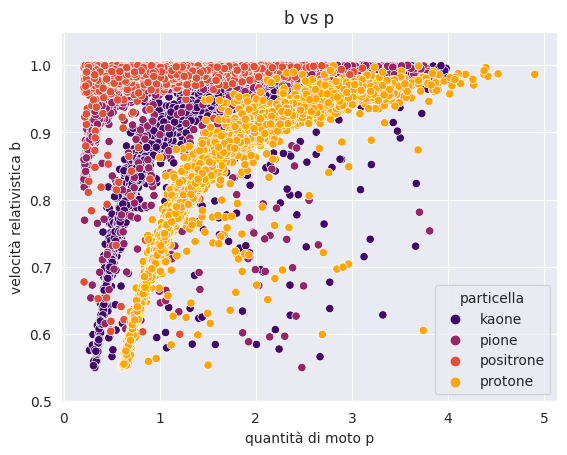

In [76]:
with sns.axes_style("darkgrid"):
    sns.scatterplot(
        data=df_us,
        x='p',
        y='beta',
        hue='particella',
        palette = 'inferno'
        ).set(xlabel='quantità di moto p',
              ylabel='velocità relativistica b',
              title = "b vs p",
              ylim = (0.5,1.05))

Ricordando le masse delle particelle ho che:

$$m_{e^+} < m_{\pi} < m_{K} < m_{p}$$

Il comportamento delle diverse particelle è distinguibile in base alle loro masse: infatti, i *positroni* che sono i leptoni *più leggeri* sono prossimi al limite relativistico ($\beta\approx1$), mentre i *protoni* che sono gli adroni *più pesanti* sono presenti nella parte inferiore del plot.

Mi creo una funzione che mi faccia vedere visivamente come le particelle si distribuiscono rispetto le loro feature
e uso uno "kernel density estimition plot KDE" che è più facile da interpretare. "Stima kernel di densità" (https://it.wikipedia.org/wiki/Stima_kernel_di_densit%C3%A0). Si può usare anche displot e come parametro kind = "kde"

In [18]:
def distribuzione(colonna, target = 'particella'):
    for tag in df_us[target].unique(): #Plotto un grafico per ogni tipo di particella
        with sns.axes_style("darkgrid"):
            sns.kdeplot(data=df_us[df_us[target] == tag][colonna], label = tag, palette = 'inferno')
    with sns.axes_style("darkgrid"):
        sns.kdeplot(data=df_us[colonna],label = "Tutte", fill = True, palette = 'inferno')
    plt.legend()

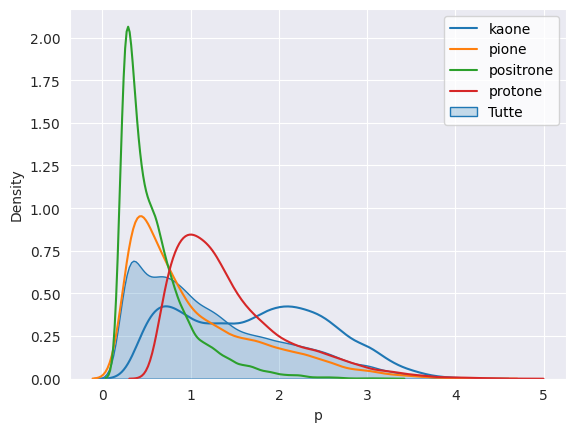

In [19]:
distribuzione('p')

## **Seconda Parte: Scelta del modello e Addestramento**

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

## **Classificazione Supervisionata: sto selezionando io le classi**
Random forests is a set of multiple decision trees.
Deep decision trees may suffer from overfitting, but random forests prevents overfitting by creating trees on random subsets.
Decision trees are computationally faster.
Random forests is difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [21]:
x = df_us.drop(columns = ['particella']) # Le features ovviamente sono tutte quelle tranne il nome della particella
y = df_us['particella'] #label

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 3, train_size = 0.8)

## **Albero Decisionale**

In [22]:
dt_class = DecisionTreeClassifier()
dt_class.fit(x_train, y_train)
y_pred_dt = dt_class.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print('Accuratezza DecisionTree:\n{:.2%}'.format(dt_accuracy))


Accuratezza DecisionTree:
89.67%


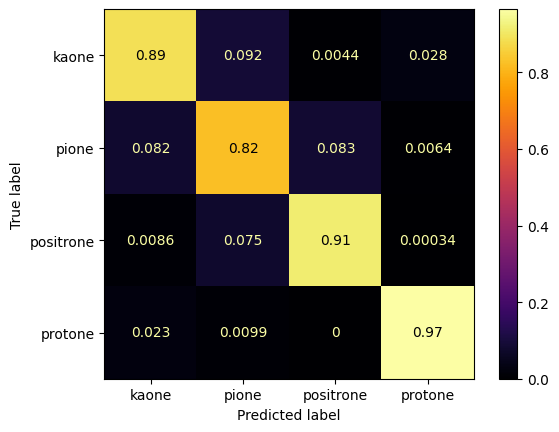

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='inferno', normalize = 'pred')

## **Random Forest**

In [24]:
rf_class = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_class.fit(x_train, y_train)
y_pred_rf = rf_class.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print('Accuratezza RandomForest:\n{:.2%}'.format(rf_accuracy))

Accuratezza RandomForest:
92.89%


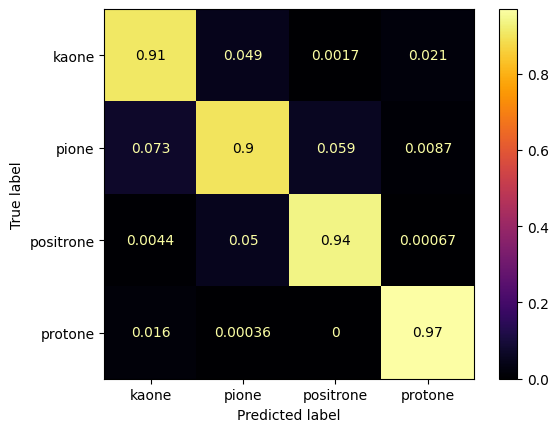

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='inferno', normalize = 'pred')

Valuto l'importanza delle features "feature_importances_"

In [26]:
importanza = pd.DataFrame(data={'Feature': x_train.columns,
                                'Importanza': rf_class.feature_importances_})
importanza.head()

,Feature,Importanza
0,p,0.309703
1,theta,0.053433
2,beta,0.470789
3,ein,0.099666
4,eout,0.066410


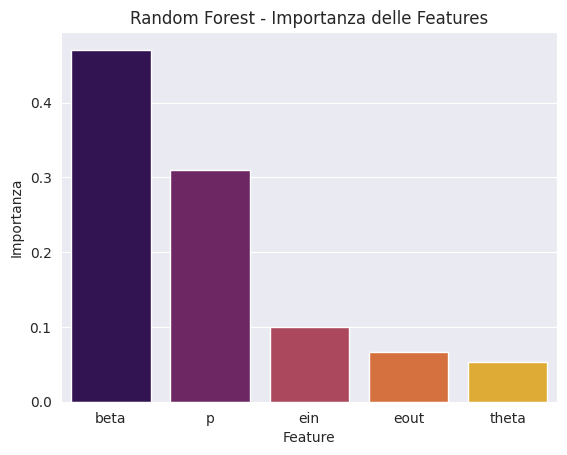

In [27]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = importanza,
                x=importanza['Feature'],
                y=importanza['Importanza'], 
                order = importanza.sort_values('Importanza',ascending = False).Feature, 
                palette = 'inferno').set(title = "Random Forest - Importanza delle Features")

Come si può vedere è la qdm insieme alla velocità relativistica come features ad essere importanti per l'addestramento del modello e la successiva predizione. Si poteva aspettare dal plot delle velocità, attaverso il quale è possibile distinguere l'andamento delle particelle.

## **Multilayer Perceptron**

Cerco di ottimizzare gli iperparametri passati al MLPClassifier:
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [28]:
griglia_parametri = [
    
        {
            'activation' : ['logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(5,),(10,),(100,)]
        }
       ]

# I migliori parametri per il MLPClassifier sono:
# {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [29]:
mlp_class = MLPClassifier(max_iter=10)
mlp_upgrade = GridSearchCV(mlp_class, griglia_parametri, n_jobs=-1)
mlp_upgrade.fit(x_train, y_train)

print("I migliori parametri per il MLPClassifier sono:\n{}\n".format(mlp_upgrade.best_params_))

y_pred_mlp = mlp_upgrade.predict(x_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)

print('Accuratezza RandomForest:\n{:.2%}'.format(mlp_accuracy))

I migliori parametri per il MLPClassifier sono:
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Accuratezza RandomForest:
86.27%


c:\Users\Marco Cecca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


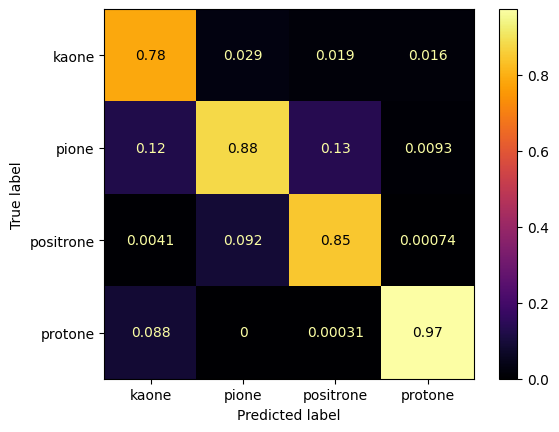

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap='inferno', normalize = 'pred')

## **Confronto dell'efficienza dei modelli**

In [31]:
accuracy_vector = np.array([dt_accuracy, rf_accuracy, mlp_accuracy])
classificatori = np.array(['Decision Tree', 'Random Forest', 'Multilayer Perceptron'])

df = pd.DataFrame({"Classifier": classificatori,
                   "Accuracy": accuracy_vector})

df

,Classifier,Accuracy
0,Decision Tree,0.896700
1,Random Forest,0.928944
2,Multilayer Perceptron,0.862687


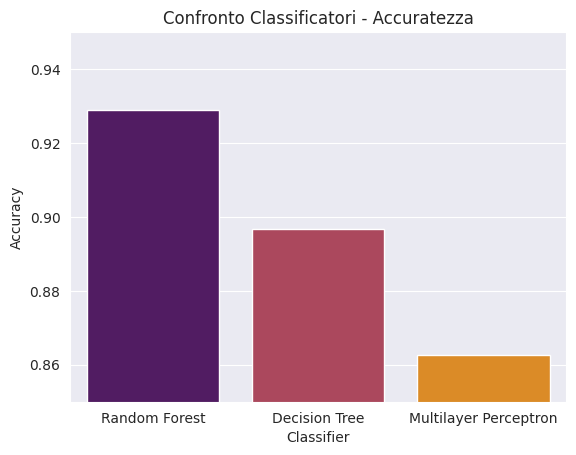

In [32]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = df, x=df['Classifier'], y=df['Accuracy'], 
                order = df.sort_values('Accuracy',ascending = False).Classifier, 
                palette = 'inferno').set(title = "Confronto Classificatori - Accuratezza",
                                        ylim=(0.85,0.95))